In [1]:
import sys
import os
from pathlib import Path 
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt
import pickle
modulepath = Path.cwd().parent / "utils"
modulepath = str(modulepath)
projectpath = Path.cwd().parent
projectpath = str(projectpath)
if modulepath not in sys.path:
    sys.path.insert(0,str(modulepath))
if projectpath not in sys.path:
    sys.path.insert(0,str(projectpath))  
print(sys.path)


['c:\\Users\\oriol\\GitHub_Repos\\CNN-classification', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\utils', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\python312.zip', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\DLLs', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126', '', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\Pythonwin']


In [2]:
from utils.data_loaders import create_train_test_dataloaders
transform = v2.Compose([v2.RandomCrop(size=(20, 20))])#,v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


In [4]:
train_basic,test_basic = create_train_test_dataloaders(dataset_name="FashionMNIST",size=0.1)
train_augmented,test_augmented = create_train_test_dataloaders(dataset_name="FashionMNIST",transform=transform)
img_basic,label_basic = next(iter(train_basic))
img_augmented,label_augmented = next(iter(train_augmented))

32


In [4]:
train_basic,test_basic = create_train_test_dataloaders("some spaces are good")

print(train_basic.dataset.root.split("\\")[-1])
name = os.path.split(os.path.normpath(train_basic.dataset.root))[-1]
print(name)

some spaces are good
some spaces are good


(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

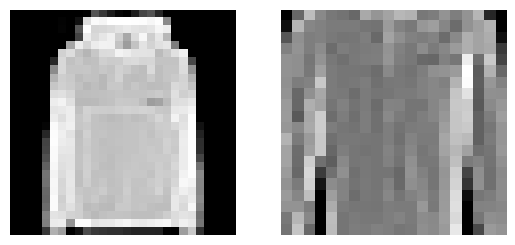

In [5]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(img_basic[0].permute(1,2,0),cmap="gray")
ax[1].imshow(img_augmented[0].permute(1,2,0),cmap="gray")
ax[0].axis(False)
ax[1].axis(False)

In [6]:
img_basic.shape

torch.Size([32, 1, 28, 28])

In [7]:
from utils.model_architectures import TinyVGG_1
from torchinfo import summary 

tvgg = TinyVGG_1(1,20,10)

In [8]:
summary(tvgg,input_size=[32,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG_1                                [32, 10]                  --
├─Sequential: 1-1                        [32, 20, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 20, 26, 26]          200
│    └─ReLU: 2-2                         [32, 20, 26, 26]          --
│    └─Conv2d: 2-3                       [32, 20, 24, 24]          3,620
│    └─ReLU: 2-4                         [32, 20, 24, 24]          --
│    └─MaxPool2d: 2-5                    [32, 20, 12, 12]          --
├─Sequential: 1-2                        [32, 20, 4, 4]            --
│    └─Conv2d: 2-6                       [32, 20, 10, 10]          3,620
│    └─ReLU: 2-7                         [32, 20, 10, 10]          --
│    └─Conv2d: 2-8                       [32, 20, 8, 8]            3,620
│    └─ReLU: 2-9                         [32, 20, 8, 8]            --
│    └─MaxPool2d: 2-10                   [32, 20, 4, 4]            --
├─Seq

In [9]:
tvgg.cpu()
tvgg.forward(img_basic[0].unsqueeze(dim=0))
torch.softmax(tvgg.forward(img_basic[0].unsqueeze(dim=0)),1)

#next(tvgg.parameters()).is_cuda #check if model on cuda

tensor([[0.1039, 0.0984, 0.0970, 0.0983, 0.0958, 0.0985, 0.1001, 0.1020, 0.1042,
         0.1018]], grad_fn=<SoftmaxBackward0>)

In [ ]:
from utils.engine import train
from utils.model_architectures import TinyVGG_1
from utils.data_loaders import create_train_test_dataloaders
from torch import nn
from utils.helpers import create_writer
from utils.helpers import create_experiment_metadata
train_dataloader, test_dataloader = create_train_test_dataloaders(size=0.1) #type: ignore
    
device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = TinyVGG_1(input_shape=1,hidden_channels=10,output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)
#print(f"Is the model on GPU {next(model_0.parameters()).is_cuda}")

model_name = model_0._get_name()
experiment_name = "Test_train_function"
extra = "1 epochs"
NUM_EPOCHS = 1

writer = create_writer(experiment_name=experiment_name,model_name=model_name,extra=extra)

train(model=model_0,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=NUM_EPOCHS,writer=writer)


[INFO] Created SummaryWriter, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs\TinyVGG_1\Test_train_function\1 epochs...
[INFO] Created experiment metadata, saving to: c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs_metadata\TinyVGG_1\Test_train_function\1 epochs...


  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
from utils.data_loaders import create_train_test_dataloaders
from torchvision import datasets 
from utils.config import DATA_DIRECTORY
mnist = os.path.join(DATA_DIRECTORY,"FashionMNIST")
train_dataset = datasets.FashionMNIST(root=mnist,train=True,download=False,transform=v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True)]))
train_basic,test_basic = create_train_test_dataloaders("FashionMNIST")


In [ ]:
print(f"Initial len {len(train_dataset)}, initial type {type(train_dataset)}")
size = 0.1
nel = int(len(train_dataset)*size)
train_dataset.data = train_dataset.data[0:nel]
print(f"Final len {len(train_dataset)}, final type {type(train_dataset)}")


Initial len 600, initial type <class 'torchvision.datasets.mnist.FashionMNIST'>
470400
Final len 60, final type <class 'torchvision.datasets.mnist.FashionMNIST'>


In [2]:
from utils.config import RUNS_METADATA_DIRECTORY
from utils.config import METADATA_FILENAME

def retrieve_metadata(model_name:str, experiment_name:str, extra=None):
    """AAA"""
    if extra:
        metadata_path = os.path.join(RUNS_METADATA_DIRECTORY, model_name, 
                               experiment_name, extra, METADATA_FILENAME)
    else:
        metadata_path = os.path.join(RUNS_METADATA_DIRECTORY, model_name, 
                               experiment_name, METADATA_FILENAME)
    if os.path.exists(metadata_path):
        with open(metadata_path, 'rb') as file:
            metadata = pickle.load(file)
        return metadata
    else:
        print(f"No metadata stored in {metadata_path}")

In [8]:

meta_dict = retrieve_metadata(model_name="TinyVGG_1", experiment_name="iwhrsgir", extra="3 epochs SDG")


No metadata stored in c:\Users\oriol\GitHub_Repos\CNN-classification\runs_metadata\TinyVGG_1\iwhrsgir\3 epochs SDG\Metadata.pkl


In [7]:
print(meta_dict)

{'date': '20-08-2025', 'experiment name': 'Test_writer_and_metadata', 'model name': 'TinyVGG_1', 'learning rate': 0.01, 'epochs': 3, 'loss function': 'CrossEntropyLoss', 'optimizer name': 'SGD', 'dataset': 'some spaces are good', 'training dataset size': 60000, 'testing dataset size': 10000, 'batch size': 32, 'optimizer params': {'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None}, 'model params': {'layer_1': Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), 'layer_2': Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [71]:
from utils.config import RUNS_DIRECTORY
print(RUNS_DIRECTORY)
exlog = os.path.dirname(RUNS_DIRECTORY)
print(exlog)
if exlog not in sys.path:
    sys.path.insert(0,str(exlog))
print(sys.path)

c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs\runs
c:\Users\oriol\GitHub_Repos\CNN-classification\experiment_logs
['c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\experiment_logs', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\experiment_logs\\runs', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification', 'c:\\Users\\oriol\\GitHub_Repos\\CNN-classification\\utils', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\python312.zip', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\DLLs', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126', '', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\oriol\\anaconda3\\envs\\pytorch_cu126\\Lib\\site-packages\\Pythonwin']


In [ ]:
from utils.engine import train
from utils.model_architectures import TinyVGG_1
from utils.data_loaders import create_train_test_dataloaders
from torch import nn
from utils.helpers import create_writer
from utils.helpers import create_experiment_metadata
train_dataloader, test_dataloader = create_train_test_dataloaders()

device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = TinyVGG_1(input_shape=1,hidden_channels=10,output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [ ]:
optimizer.__getstate__()['defaults']

In [ ]:
model_0.__getstate__()['_modules']

In [ ]:
import pickle
with open(r"C:\Users\oriol\GitHub_Repos\CNN-classification\runs_metadata\TinyVGG_1\Test_writer_and_dict\2 epochs\Metadata.pkl", 'rb') as file:
    meta_dict = pickle.load(file)

In [ ]:
print(meta_dict)

In [ ]:
wrtr.__getstate__()['log_dir']

In [ ]:
import os
from utils.config import RUNS_DIRECTORY
from utils.helpers import create_writer
wrtr = create_writer(model_name="None",experiment_name="Test expname extraction",extra="Please")

relpath = os.path.normpath(os.path.relpath(wrtr.__getstate__()['log_dir'],RUNS_DIRECTORY))
components = relpath.split(os.sep)

In [ ]:
print(f"Model name '{components[0]}' and experiment name '{components[1]}'")
type(components[0])

In [ ]:
from utils.model_architectures import TinyVGG_1

device = "cuda" if torch.cuda.is_available() else "cpu"

model_0 = TinyVGG_1(input_shape=1,hidden_channels=10,output_shape=10).to(device)

In [ ]:
from utils.config import RUNS_METADATA_DIRECTORY
dictpath = os.path.join(RUNS_METADATA_DIRECTORY,relpath)
print(dictpath)

In [ ]:
import os
from utils.config import RUNS_METADATA_DIRECTORY
import pickle
metadata_file = os.path.join(RUNS_METADATA_DIRECTORY,"TinyVGG_1","Test_writer_and_newdict","1 epochs","Metadata.pkl")
with open(metadata_file, 'rb') as f:
    resdict = pickle.load(f)

In [ ]:
resdict

In [13]:
from datetime import datetime 

print(datetime.now().strftime("%d-%m-%Y %H:%M"))


21-08-2025 12:24


In [10]:
from utils.model_architectures import TinyVGG_1
loaded_model = TinyVGG_1(1,10,10)
loaded_model.load_state_dict(torch.load(f=r"C:\Users\oriol\GitHub_Repos\CNN-classification\models\Untrained_TinyVGG_1.pth")) 

<All keys matched successfully>